## 基于TensorFlow+CNN实现猫狗识别

### 6 制作TFRecords
+ 生成tfrecord-1文件
+ TFRecords作用：高效读取数据，将数据进行序列化存储，便于网络流式读取数据，是常用的存储二进制序列的方法
+ tf.example类：将数据表示为{"string": value}形式的meassage类型，常用于写入、读取TFRecords数据
+ tf.example格式：tf.train.BytesList用于string和byte，tf.train.FloatList用于float和double，tf.train.Int64List用于枚举enum、bool、int32、unit32、int64

##### 6.1 转化实例

In [1]:
import warnings
warnings.filterwarnings("ignore")   # 忽略警告消息
import tensorflow as tf
import numpy as np

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):   # tf.constant()创建常量
        value = value.numpy()   # 将Tensor转化为ndarray
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))   # string和byte

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))   # float和double

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))   # 枚举enum、bool、int32、unit32、int64

print(_bytes_feature(b'test_string'))
print(_bytes_feature('test_string'.encode('utf-8')))

print(_float_feature(np.exp(1)))

print(_int64_feature(True))   # bool型
print(_int64_feature(1))   # 数值型

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_string"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



##### 6.2 制作方法

In [2]:
def serialize_example(feature0, feature1, feature2, feature3):   # 创建tf.example
    feature = {   # 转换成相应类型
        'feature0': _int64_feature(feature0),
        'feature1': _int64_feature(feature1),
        'feature2': _bytes_feature(feature2),   
        'feature3': _float_feature(feature3),       
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))   # 将features编码数据封装成特定的PB协议格式
    return example_proto.SerializeToString()   # 转换为二进制字符串

# 随机生成特征数据
n_observations = int(1e4)   # 数据量
feature0 = np.random.choice([False, True], n_observations)   # 随机生成布尔型
feature1 = np.random.randint(0, 5, n_observations)   # 随机生成整型
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]   # 字符串型（基于五个字符生成10000个字符串）
feature3 = np.random.randn(n_observations)   # 随机生成浮点型

# 读取数据
filename = 'tfrecord-1'
with tf.io.TFRecordWriter(filename) as writer:   # 输出TFrecord的API
    for i in range(n_observations):
        example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
        writer.write(example)

##### 6.3 加载文件

In [3]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)   # 读取
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

### 7 图像数据处理的TFRecords实例
+ 文件保存在data3文件夹中，生成tfrecord-1文件

##### 7.1 读取数据和展示图像

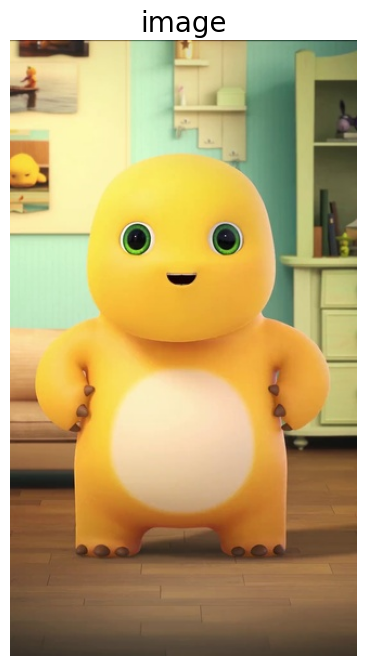

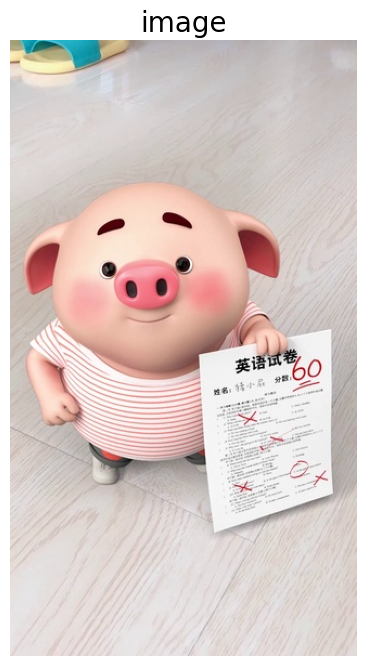

In [73]:
import os
import glob
import datetime   # 处理日期和时间
import cv2
import numpy as np
import matplotlib.pyplot as plt   # 显示图片
import matplotlib.image as mping   # 读取图片
import tensorflow as tf
%matplotlib inline

image_path = './data3/'
images = glob.glob(os.path.join(image_path, '*.jpg'))

for fname in images:
    image = mping.imread(fname)   # 读取图片
    f, (axl) = plt.subplots(1, 1, figsize=(8, 8))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axl.axis('off')  # 去掉坐标轴
    axl.imshow(image)
    axl.set_title('image', fontsize=20)
    
image_label = {'nailong': 0, 'zhuxiaopi': 1}

##### 7.2 制作TFRecords(一张图片样本)

In [74]:
image_string = open('./data3/nailong.jpg', 'rb').read()   # 读取数据，binary格式
label = image_label['nailong']

def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):   # tf.constant()创建常量
        value = value.numpy()   # 将Tensor转化为ndarray
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))   # string和byte

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))   # float和double

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))   # 枚举enum、bool、int32、unit32、int64

# 创建图像数据的Example
def image_example(image_string, label):
    image_shape = tf.image.decode_jpeg(image_string).shape   # jpg也适用
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string)
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))   # 将features编码数据封装成特定的PB协议格式

# 打印部分信息
image_example_proto = image_example(image_string, label)
for line in str(image_example_proto).split('\n')[:15]:
    print(line)   # 输出前14行

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 569
      }


In [75]:
# 读取数据
record_file = 'tfrecord-2'
counter = 0

with tf.io.TFRecordWriter(record_file) as writer:   # 输出TFrecord的API
    for fname in images:
        with open(fname, 'rb') as f:
            image_string = f.read()
            label = image_label[os.path.basename(fname).replace('.jpg', '')]
            tf_example = image_example(image_string, label)   # 创建tf.example 
            writer.write(tf_example.SerializeToString())   # 将tf.example写入TFRecord
            counter += 1
            print('Processed {:d} of {:d} images.'.format(counter, len(images)))
print('Wrote {} images to {}'.format(counter, record_file))

Processed 1 of 2 images.
Processed 2 of 2 images.
Wrote 2 images to tfrecord-2


In [79]:
# 加载制作好的TFRecord
raw_train_dataset = tf.data.TFRecordDataset(record_file)
raw_train_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

##### 7.3 解析TFRecords
+ 举例的数据进行了序列化，因此需要解析之前写入的序列化string

In [77]:
# 解析的格式需要跟之前创建的example时一致
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string)
}

In [89]:
# 定义映射规则map，对多个样本解析
def parse_tf_example(image_example_proto):
    parsed_example = tf.io.parse_single_example(image_example_proto, image_feature_description)   # 解析数据
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)   # 预处理
    x_train = tf.image.resize(x_train, [256, 256])
    label = parsed_example['label']
    y_train = label
    return x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

##### 7.4 制作训练集

In [90]:
num_epochs = 10
train_ds = train_dataset.shuffle(buffer_size=1000).batch(2).repeat(num_epochs)   # shuffle随机洗牌此数据集的元素
train_ds

<RepeatDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [86]:
for batch, (x, y) in enumerate(train_ds):
    print(batch, x.shape, y)

0 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
1 (2, 256, 256, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
2 (2, 256, 256, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
3 (2, 256, 256, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
4 (2, 256, 256, 3) tf.Tensor([1 0], shape=(2,), dtype=int64)
5 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
6 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
7 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
8 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)
9 (2, 256, 256, 3) tf.Tensor([0 1], shape=(2,), dtype=int64)


In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.fit(train_ds, epochs=num_epochs)

Epoch 1/10


10/10 [==============================] - 0s 10ms/step - loss: 12102.9746 - accuracy: 0.5500
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 616.1318 - accuracy: 0.9000
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accurac